In [1]:
import sys
print(sys.executable)
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install catboost
!{sys.executable} -m pip install lightgbm
!{sys.executable} -m pip install tensorflow


/opt/homebrew/opt/python@3.10/bin/python3.10

[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
import pandas as pd

# STEP 1: LOAD DATASET
file_path = "./XAU_USD Historical Data.csv"
df = pd.read_csv(file_path)


# STEP 2: DATA CLEANING

# 1. Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")

# 2. Remove commas and convert price columns to float
price_columns = ["Price", "Open", "High", "Low"]

for col in price_columns:
    df[col] = df[col].str.replace(",", "").astype(float)

# 3. Drop columns that cause leakage or are useless
df = df.drop(columns=["Vol.", "Change %"])

# 4. Sort data chronologically (oldest → newest)
df = df.sort_values("Date").reset_index(drop=True)

# STEP 2: SANITY CHECK
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing Values:\n", df.isna().sum())

# Preview cleaned data
df.head()


Dataset Shape: (5000, 5)

Columns: ['Date', 'Price', 'Open', 'High', 'Low']

Missing Values:
 Date     0
Price    0
Open     0
High     0
Low      0
dtype: int64


,Date,Price,Open,High,Low
0,2005-01-03,428.95,437.85,428.95,428.95
1,2005-01-04,427.65,429.60,427.65,427.65
2,2005-01-05,426.55,427.55,426.55,426.55
3,2005-01-06,421.32,426.77,421.32,421.32
4,2005-01-07,418.95,421.75,418.95,418.95


In [4]:
# STEP 3: Technical Indicators Calculation

import numpy as np


# 1. RSI (Relative Strength Index)
rsi_window = 14

delta = df["Price"].diff()
gain = delta.where(delta > 0, 0.0)
loss = -delta.where(delta < 0, 0.0)

avg_gain = gain.rolling(rsi_window).mean()
avg_loss = loss.rolling(rsi_window).mean()

rs = avg_gain / avg_loss
df["RSI"] = 100 - (100 / (1 + rs))



# 2. MACD (Moving Average Convergence Divergence)
ema_12 = df["Price"].ewm(span=12, adjust=False).mean()
ema_26 = df["Price"].ewm(span=26, adjust=False).mean()

df["MACD"] = ema_12 - ema_26
df["MACD_signal"] = df["MACD"].ewm(span=9, adjust=False).mean()



# 3. EMA (Exponential Moving Average)
df["EMA_20"] = df["Price"].ewm(span=20, adjust=False).mean()



# 4. Bollinger Bands
bb_window = 20

sma = df["Price"].rolling(bb_window).mean()
std = df["Price"].rolling(bb_window).std()

df["BB_upper"] = sma + (2 * std)
df["BB_lower"] = sma - (2 * std)



# 5. ATR (Average True Range)
high_low = df["High"] - df["Low"]
high_close = (df["High"] - df["Price"].shift()).abs()
low_close = (df["Low"] - df["Price"].shift()).abs()

true_range = pd.concat(
    [high_low, high_close, low_close],
    axis=1
).max(axis=1)

df["ATR"] = true_range.rolling(14).mean()



# 6. Remove rows with NaN values
df = df.dropna().reset_index(drop=True)



# 7. Final sanity check
print("Final Dataset Shape:", df.shape)
print("\nFinal Columns:")
print(df.columns.tolist())

df.head()


Final Dataset Shape: (4962, 12)

Final Columns:
['Date', 'Price', 'Open', 'High', 'Low', 'RSI', 'MACD', 'MACD_signal', 'EMA_20', 'BB_upper', 'BB_lower', 'ATR']


,Date,Price,Open,High,Low,RSI,MACD,MACD_signal,EMA_20,BB_upper,BB_lower,ATR
0,2005-02-24,434.12,434.27,434.12,434.12,88.760921,2.247444,0.412986,426.251136,437.052921,409.457079,1.798571
1,2005-02-25,434.93,433.62,434.93,434.93,90.504103,2.633682,0.857126,427.077695,438.349492,408.973508,1.827857
2,2005-02-28,435.62,434.88,435.62,435.62,95.860129,2.961319,1.277964,427.891248,439.926757,408.696243,1.777143
3,2005-03-01,432.75,435.65,432.75,432.75,85.781991,2.955321,1.613436,428.353986,440.869841,408.918159,1.959286
4,2005-03-02,432.65,432.35,432.65,432.65,82.631350,2.908966,1.872542,428.763130,441.703426,409.151574,1.645000


In [5]:
import numpy as np

# STEP 4: TARGET LABEL GENERATION

# 1. Shift price to get next-day price
df["Next_Price"] = df["Price"].shift(-1)

# 2. Define BUY / NOT BUY target
# BUY (1) if next day's price is higher
# NOT BUY (0) otherwise
# df["Target"] = np.where(
#     df["Next_Price"] > df["Price"], 1, 0
# )


# another method for labeling
# vol = df["Price"].pct_change().rolling(20).std()

# df["Target"] = np.where(
#     (df["Next_Price"] - df["Price"]) / df["Price"] > vol,
#     1,
#     0
# )


# ret = (df["Next_Price"] - df["Price"]) / df["Price"]
# vol = ret.rolling(20).std()

# df["Target"] = np.where(
#     (ret > 1.5 * vol) &      # strong move
#     (df["MACD"] > df["MACD_signal"]) &  # trend confirmation
#     (df["RSI"] > 50),        # momentum confirmation
#     1,
#     0
# )
# df = df.dropna().reset_index(drop=True)



# ret = (df["Next_Price"] - df["Price"]) / df["Price"]
# vol = ret.rolling(20).std()

# df["Target"] = np.where(
#     (ret > 0.45 * vol) &              # less strict move
#     (df["MACD"] > df["MACD_signal"]) &  # trend confirmation
#     (df["RSI"] > 25),                # softer momentum
#     1,
#     0
# )




ret = (df["Next_Price"] - df["Price"]) / df["Price"]
(macd_trend := df["MACD"].diff() > 0)


# Rolling volatility (for mild filtering, not strict)
vol = ret.rolling(20).std()

df["Target"] = np.where(
    # Moderate positive move (easy to satisfy)
    (ret > 0.4 * vol) &

    # Trend alignment (very important)
    (df["Price"] > df["EMA_20"]) &

    # Momentum confirmation (soft)
    (df["RSI"] > 40),

    1,  # BUY
    0   # NOT BUY
)

df = df.dropna().reset_index(drop=True)






# 3. Remove last row (no future price available)
df = df.dropna().reset_index(drop=True)

# 4. Sanity check
print("Target distribution:")
print(df["Target"].value_counts())

df[["Date", "Price", "Next_Price", "Target"]].head()


Target distribution:
Target
0    4010
1     951
Name: count, dtype: int64


,Date,Price,Next_Price,Target
0,2005-02-24,434.12,434.93,0
1,2005-02-25,434.93,435.62,0
2,2005-02-28,435.62,432.75,0
3,2005-03-01,432.75,432.65,0
4,2005-03-02,432.65,430.27,0


In [8]:
# STEP 5: TIME-AWARE TRAIN–TEST SPLIT

# 1. Define feature columns (NO Date, NO Target)
feature_columns = [
    "Price", "Open", "High", "Low",
    "RSI", "MACD", "MACD_signal",
    "EMA_20", "BB_upper", "BB_lower", "ATR"
]

df = df.dropna().reset_index(drop=True)



# x is features and y is target
X = df[feature_columns]
y = df["Target"]

# 2. Determine split index (80% train, 20% test)
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

# 3. Time-based split
X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

# 4. Sanity checks
print("Total samples:", len(df))
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

print("\nTraining target distribution:")
print(y_train.value_counts())

print("\nTesting target distribution:")
print(y_test.value_counts())


Total samples: 4961
Training samples: 3968
Testing samples: 993

Training target distribution:
Target
0    3199
1     769
Name: count, dtype: int64

Testing target distribution:
Target
0    811
1    182
Name: count, dtype: int64


In [9]:
# STEP 6: XGBOOST MODEL TRAINING


from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Define XGBoost model
# xgb_model = XGBClassifier(
#     n_estimators=200,        # number of trees
#     max_depth=5,             # tree depth
#     learning_rate=0.05,      # step size
#     subsample=0.8,           # row sampling
#     colsample_bytree=0.8,    # feature sampling
#     objective="binary:logistic",
#     eval_metric="logloss",
#     random_state=42
# )

import pandas as pd



neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=9000,
    max_depth=3,                # shallow trees generalize better
    learning_rate=0.02,
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=0.2,                  # penalize weak splits
    min_child_weight=3,
    scale_pos_weight=scale_pos_weight,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    reg_lambda = 10
)



xgb_model.fit(X_train, y_train)



fi = pd.Series(
    xgb_model.feature_importances_,
    index=feature_columns
).sort_values()

print(fi)




# 2. Train the model
xgb_model.fit(X_train, y_train)

# 3. Make predictions
# y_pred = xgb_model.predict(X_test)
df = df.dropna().reset_index(drop=True)



from sklearn.metrics import accuracy_score, precision_score
y_prob = xgb_model.predict_proba(X_test)[:, 1]


for t in [0.55, 0.58, 0.60, 0.62, 0.65]:
    y_pred = (y_prob > t).astype(int)
    acc = accuracy_score(y_test, y_pred) * 100
    prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    buys = y_pred.sum()
    print(f"thr={t} | acc={acc:.2f}% | buy_prec={prec:.2f} | buys={buys}")



# 4. Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("XGBoost Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


High           0.077917
Open           0.078683
BB_upper       0.080629
Price          0.081612
Low            0.081664
ATR            0.081806
EMA_20         0.083789
BB_lower       0.085355
MACD_signal    0.091131
MACD           0.104595
RSI            0.152819
dtype: float32
thr=0.55 | acc=81.47% | buy_prec=0.44 | buys=18
thr=0.58 | acc=81.47% | buy_prec=0.44 | buys=18
thr=0.6 | acc=81.47% | buy_prec=0.44 | buys=18
thr=0.62 | acc=81.17% | buy_prec=0.33 | buys=15
thr=0.65 | acc=81.27% | buy_prec=0.36 | buys=14
XGBoost Accuracy: 0.8126888217522659

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90       811
           1       0.36      0.03      0.05       182

    accuracy                           0.81       993
   macro avg       0.59      0.51      0.47       993
weighted avg       0.73      0.81      0.74       993


Confusion Matrix:
[[802   9]
 [177   5]]

Confusion Matrix:
[[802   9]
 [177   5]]


In [10]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
# Always predict NOT BUY
baseline_accuracy = max(y_test.mean(), 1 - y_test.mean())
print("Baseline Accuracy:", baseline_accuracy)


              precision    recall  f1-score   support

           0       0.82      0.99      0.90       811
           1       0.36      0.03      0.05       182

    accuracy                           0.81       993
   macro avg       0.59      0.51      0.47       993
weighted avg       0.73      0.81      0.74       993

Baseline Accuracy: 0.8167170191339376


In [11]:
# CATBOOST MODEL (BUY / NOT BUY)
# ==============================

import numpy as np
import pandas as pd

from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_score,
    confusion_matrix
)

# ------------------------------
# 1. FEATURE SELECTION (INDICATORS ONLY)
# ------------------------------
feature_columns = [
    "RSI",
    "MACD",
    "MACD_signal",
    "EMA_20",
    "BB_upper",
    "BB_lower",
    "ATR"
]

ret = (df["Next_Price"] - df["Price"]) / df["Price"]
vol = ret.rolling(20).std()

macd_trend = df["MACD"].diff() > 0

df["Target"] = np.where(
    (ret > 0.3 * vol) &
    (df["Price"] > df["EMA_20"]) &
    (df["RSI"] > 40) &
    macd_trend,
    1,
    0
)

df = df.dropna().reset_index(drop=True)



X = df[feature_columns]
y = df["Target"]

# ------------------------------
# 2. TIME-AWARE TRAIN–TEST SPLIT
# ------------------------------
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

# ------------------------------
# 3. HANDLE CLASS IMBALANCE
# ------------------------------
neg, pos = np.bincount(y_train)
class_weights = [1.0, neg / pos]

# ------------------------------
# 4. CATBOOST MODEL
# ------------------------------
cat_model = CatBoostClassifier(
    iterations=1600,
    depth=3,
    learning_rate=0.1,
    loss_function="Logloss",
    eval_metric="Logloss",
    class_weights=class_weights,
    random_seed=42,
    verbose=False
)

cat_model.fit(X_train, y_train)

# ------------------------------
# 5. CUSTOM THRESHOLD PREDICTION
# ------------------------------
y_prob = cat_model.predict_proba(X_test)[:, 1]

threshold = 0.9   # try 0.55 / 0.6 / 0.65
y_pred = (y_prob > threshold).astype(int)

# ------------------------------
# 6. EVALUATION
# ------------------------------
accuracy = accuracy_score(y_test, y_pred) * 100
buy_precision = precision_score(y_test, y_pred, pos_label=1)

print(f"Accuracy: {accuracy:.2f}%")
print(f"BUY Precision: {buy_precision * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 85.30%
BUY Precision: 0.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       847
           1       0.00      0.00      0.00       146

    accuracy                           0.85       993
   macro avg       0.43      0.50      0.46       993
weighted avg       0.73      0.85      0.79       993

Confusion Matrix:
[[847   0]
 [146   0]]


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/lib/python3.10/site-pa

Accuracy: 85.30%
BUY Precision: 50.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       847
           1       0.50      0.08      0.13       146

    accuracy                           0.85       993
   macro avg       0.68      0.53      0.53       993
weighted avg       0.81      0.85      0.80       993

Confusion Matrix:
[[836  11]
 [135  11]]


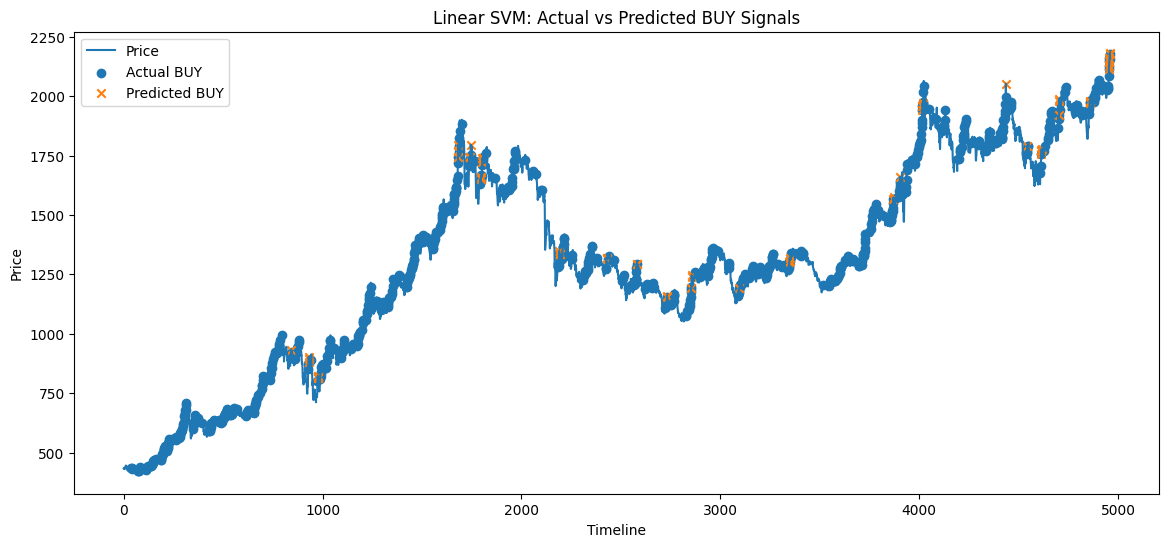

In [ ]:
# ==============================
# LINEAR SVM MODEL (BUY / NOT BUY)
# ==============================

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_score,
    confusion_matrix
)

# ------------------------------
# 1. FEATURE SELECTION (INDICATORS ONLY)
# ------------------------------
feature_columns = [
    "RSI",
    "MACD",
    "MACD_signal",
    "EMA_20",
    "BB_upper",
    "BB_lower",
    "ATR"
]

X = df[feature_columns]
y = df["Target"]

# ------------------------------
# 2. TIME-AWARE TRAIN–TEST SPLIT
# ------------------------------
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

# ------------------------------
# 3. FEATURE SCALING (MANDATORY FOR SVM)
# ------------------------------
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ------------------------------
# 4. LINEAR SVM MODEL
# ------------------------------
svm_linear = SVC(
    kernel="linear",
    C=1.0,
    class_weight="balanced",
    probability=True,
    random_state=42
)

svm_linear.fit(X_train_scaled, y_train)

# ------------------------------
# 5. PREDICTION USING CUSTOM THRESHOLD
# ------------------------------
y_prob = svm_linear.predict_proba(X_test_scaled)[:, 1]

threshold = 0.6   # adjust: 0.55 / 0.6 / 0.65
y_pred = (y_prob > threshold).astype(int)

# ------------------------------
# 6. EVALUATION
# ------------------------------
accuracy = accuracy_score(y_test, y_pred) * 100
buy_precision = precision_score(y_test, y_pred, pos_label=1)

print(f"Accuracy: {accuracy:.2f}%")
print(f"BUY Precision: {buy_precision * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))








In [13]:
print("BUY count:", y_pred.sum())

from sklearn.metrics import precision_score
print("BUY precision:",
      precision_score(y_test, y_pred, pos_label=1))


BUY count: 22
BUY precision: 0.5


In [14]:
# CUBIC SVM MODEL (BUY / NOT BUY)
# ==============================

import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    classification_report,
    confusion_matrix
)

# ------------------------------
# 1. FEATURE SELECTION (INDICATORS ONLY)
# ------------------------------
feature_columns = [
    "RSI",
    "MACD",
    "MACD_signal",
    "ATR",
    "BB_upper",
    "BB_lower",
    "EMA_20"
]

df = df.dropna().reset_index(drop=True)

X = df[feature_columns]
y = df["Target"]

# ------------------------------
# 2. TIME-AWARE TRAIN–TEST SPLIT
# ------------------------------
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

# ------------------------------
# 3. FEATURE SCALING (MANDATORY FOR SVM)
# ------------------------------
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ------------------------------
# 4. CUBIC SVM MODEL
# ------------------------------
svm_cubic = SVC(
    kernel="poly",
    degree=3,                # CUBIC
    C=1.0,                   # regularization
    coef0=1.0,               # polynomial bias
    class_weight="balanced", # handle imbalance
    probability=True,        # needed for threshold tuning
    random_state=42
)

svm_cubic.fit(X_train_scaled, y_train)

# ------------------------------
# 5. PROBABILITY + CUSTOM THRESHOLD
# ------------------------------
y_prob = svm_cubic.predict_proba(X_test_scaled)[:, 1]

threshold = 0.45   # try 0.5 / 0.55 / 0.6
y_pred = (y_prob > threshold).astype(int)

# ------------------------------
# 6. EVALUATION
# ------------------------------
accuracy = accuracy_score(y_test, y_pred) * 100
buy_precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)

print(f"Accuracy: {accuracy:.2f}%")
print(f"BUY Precision: {buy_precision:.2f}")
print("BUY Count:", y_pred.sum())

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 83.18%
BUY Precision: 0.42
BUY Count: 133

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       847
           1       0.42      0.38      0.40       146

    accuracy                           0.83       993
   macro avg       0.66      0.65      0.65       993
weighted avg       0.83      0.83      0.83       993

Confusion Matrix:
[[770  77]
 [ 90  56]]


In [15]:
# KNN MODEL (BUY / NOT BUY)
# ==============================

import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    classification_report,
    confusion_matrix
)

# ------------------------------
# 1. FEATURE SELECTION (INDICATORS ONLY)
# ------------------------------
feature_columns = [
    "RSI",
    "MACD",
    "MACD_signal",
    "ATR",
    "BB_upper",
    "BB_lower",
    "EMA_20"
]

df = df.dropna().reset_index(drop=True)

X = df[feature_columns]
y = df["Target"]

# ------------------------------
# 2. TIME-AWARE TRAIN–TEST SPLIT
# ------------------------------
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

# ------------------------------
# 3. FEATURE SCALING (MANDATORY FOR KNN)
# ------------------------------
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ------------------------------
# 4. 10-NN MODEL
# ------------------------------
knn_10 = KNeighborsClassifier(
    n_neighbors=10,     # 10-NN
    weights="distance", # closer neighbors matter more
    metric="minkowski", # Euclidean distance
    p=2
)

knn_10.fit(X_train_scaled, y_train)

# ------------------------------
# 5. PROBABILITY + CUSTOM THRESHOLD
# ------------------------------
y_prob = knn_10.predict_proba(X_test_scaled)[:, 1]

threshold = 0.55   # try 0.5 / 0.55 / 0.6
y_pred = (y_prob > threshold).astype(int)

# ------------------------------
# 6. EVALUATION
# ------------------------------
accuracy = accuracy_score(y_test, y_pred) * 100
buy_precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)

print(f"Accuracy: {accuracy:.2f}%")
print(f"BUY Precision: {buy_precision:.2f}")
print("BUY Count:", y_pred.sum())

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 85.70%
BUY Precision: 0.83
BUY Count: 6

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       847
           1       0.83      0.03      0.07       146

    accuracy                           0.86       993
   macro avg       0.85      0.52      0.49       993
weighted avg       0.85      0.86      0.80       993

Confusion Matrix:
[[846   1]
 [141   5]]


In [ ]:
# ==============================
# DECISION TREE (FINE TREE MODEL)
# ==============================

import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    classification_report,
    confusion_matrix
)

# ------------------------------
# 1. FEATURE SELECTION (INDICATORS ONLY)
# ------------------------------
feature_columns = [
    "RSI",
    "MACD"
    "MACD_signal",
    "ATR",
    "BB_upper",
    "BB_lower",
    "EMA_20"
]

df = df.dropna().reset_index(drop=True)

X = df[feature_columns]
y = df["Target"]   # 1 = BUY, 0 = NOT BUY

# ------------------------------
# 2. TIME-AWARE TRAIN–TEST SPLIT
# ------------------------------
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

# ------------------------------
# 3. FINE TREE MODEL
# ------------------------------
tree_model = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=15,          # fine tree (deeper than coarse)
    min_samples_split=20,  # avoid tiny noisy splits
    min_samples_leaf=40,   # smoother leaves
    class_weight="balanced",
    random_state=40, 
    max_features="sqrt"
)

tree_model.fit(X_train, y_train)

# ------------------------------
# 4. PROBABILITY + THRESHOLD
# ------------------------------
y_prob = tree_model.predict_proba(X_test)[:, 1]

threshold = 0.65   # try 0.5 / 0.55 / 0.6
y_pred = (y_prob > threshold).astype(int)

# ------------------------------
# 5. EVALUATION
# ------------------------------
accuracy = accuracy_score(y_test, y_pred) * 100
buy_precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)

print(f"Decision Tree Accuracy: {accuracy:.2f}%")
print(f"BUY Precision: {buy_precision:.2f}")
print("BUY Count:", y_pred.sum())

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


NameError: name 'df' is not defined

In [ ]:
# ENSEMBLE BAGGED TREE MODEL
# ==============================

import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    classification_report,
    confusion_matrix
)

# ------------------------------
# 1. FEATURE SELECTION
# ------------------------------
feature_columns = [
    "RSI",
    "MACD",
    "MACD_signal",
    "ATR",
    "BB_upper",
    "BB_lower",
    "EMA_20"
]

df = df.dropna().reset_index(drop=True)

X = df[feature_columns]
y = df["Target"]   # 1 = BUY, 0 = NOT BUY

# ------------------------------
# 2. TIME-AWARE TRAIN–TEST SPLIT
# ------------------------------
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

# ------------------------------
# 3. BASE TREE (FINE TREE)
# ------------------------------
base_tree = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=12,
    min_samples_split=30,
    min_samples_leaf=10,
    max_features="sqrt",
    class_weight={0:1, 1:0.9},
    random_state=42
)

# ------------------------------
# 4. BAGGING ENSEMBLE
# ------------------------------
bagged_tree = BaggingClassifier(
    estimator=base_tree,
    n_estimators=200,       # number of trees
    max_samples=0.8,        # bootstrap samples
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

bagged_tree.fit(X_train, y_train)

# ------------------------------
# 5. PROBABILITY + THRESHOLD
# ------------------------------
y_prob = bagged_tree.predict_proba(X_test)[:, 1]

threshold = 0.50   # try 0.45 / 0.50 / 0.55
y_pred = (y_prob > threshold).astype(int)

# ------------------------------
# 6. EVALUATION
# ------------------------------
accuracy = accuracy_score(y_test, y_pred) * 100
buy_precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)

print(f"Bagged Tree Accuracy: {accuracy:.2f}%")
# print(f"BUY Precision: {buy_precision:.2f}")
# print("BUY Count:", y_pred.sum())

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Bagged Tree Accuracy: 85.24%
BUY Precision: 0.00
BUY Count: 0

Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       849
           1       0.00      0.00      0.00       147

    accuracy                           0.85       996
   macro avg       0.43      0.50      0.46       996
weighted avg       0.73      0.85      0.78       996

Confusion Matrix:
[[849   0]
 [147   0]]


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [131]:
import joblib

# Save model
joblib.dump(xgb_model, "xgb_model.pkl")

# Save feature columns (VERY IMPORTANT)
joblib.dump(feature_columns, "feature_columns.pkl")

print("Model and feature columns saved successfully")


Model and feature columns saved successfully


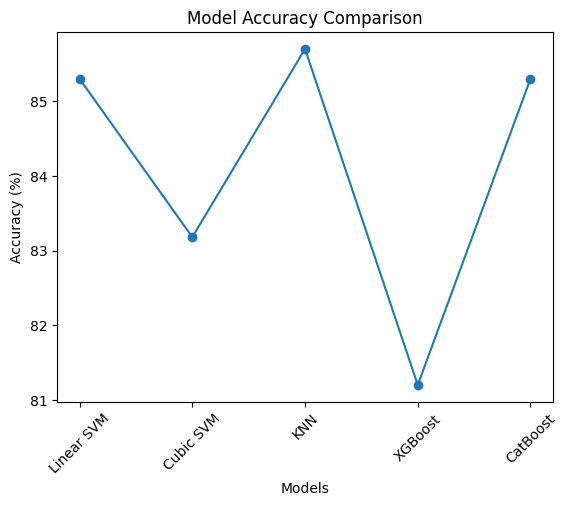

In [17]:
import matplotlib.pyplot as plt

models = ["Linear SVM", "Cubic SVM", "KNN", "XGBoost", "CatBoost"]
accuracy = [85.3, 83.18, 85.7, 81.2, 85.3]  # replace with your actual values

plt.figure()
plt.plot(models, accuracy, marker='o')
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.show()


In [22]:
# Linear SVM
y_prob_linear = svm_linear.predict_proba(X_test_scaled)[:, 1]

# Cubic SVM
y_prob_cubic = svm_cubic.predict_proba(X_test_scaled)[:, 1]

# KNN
y_prob_knn = knn_10.predict_proba(X_test_scaled)[:, 1]

# Recreate exact feature set used during XGBoost training

feature_columns_xgb = [
    "Price",
    "Open",
    "High",
    "Low",
    "RSI",
    "MACD",
    "MACD_signal",
    "EMA_20",
    "BB_upper",
    "BB_lower",
    "ATR"
]

X_test_xgb = df[feature_columns_xgb].iloc[split_index:]

y_prob_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]


# CatBoost
y_prob_cat = cat_model.predict_proba(X_test)[:, 1]


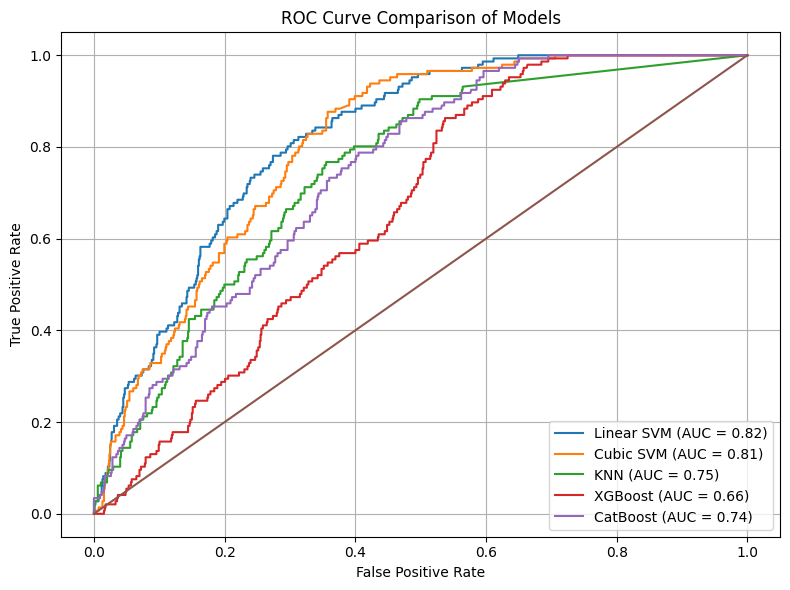

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC for each model
fpr_linear, tpr_linear, _ = roc_curve(y_test, y_prob_linear)
roc_linear = auc(fpr_linear, tpr_linear)

fpr_cubic, tpr_cubic, _ = roc_curve(y_test, y_prob_cubic)
roc_cubic = auc(fpr_cubic, tpr_cubic)

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_knn = auc(fpr_knn, tpr_knn)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_cat, tpr_cat, _ = roc_curve(y_test, y_prob_cat)
roc_cat = auc(fpr_cat, tpr_cat)

# Plot
plt.figure(figsize=(8,6))

plt.plot(fpr_linear, tpr_linear, label=f"Linear SVM (AUC = {roc_linear:.2f})")
plt.plot(fpr_cubic, tpr_cubic, label=f"Cubic SVM (AUC = {roc_cubic:.2f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {roc_knn:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_xgb:.2f})")
plt.plot(fpr_cat, tpr_cat, label=f"CatBoost (AUC = {roc_cat:.2f})")

plt.plot([0,1], [0,1])  # diagonal reference

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison of Models")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig("roc_comparison.png", dpi=300)  # saves image
plt.show()
